# Houseing Prices

## Content Table
* [Information](#Information)
* [Import](#Import)
  * [Feature Selection](#FeatureSelection)
* [Data mining and cleaning](#DMC)
  * [Data Analyse](#DataAnalyse)
  * [Data Cleaning](#DataCleaning)
* [Data Modeling](#DataModeling)
  * [Preprocessing](#Prepro)
  * [Feature Selection](#FeatSelec)
  * [Linear Regression](#LR)
* [Conclusion](#Conclusion)

## Information <a id ="Information"></a>

La target est la colonne `Sale Price` qui donne le prix de vente d'une maison.
Plus d'informations sur les valeurs et la signification des colonnes est disponible dans le fichier `data_description.txt`

Pré: Importation des packages de bases

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV


Post: Les packages sont importés

## Import <a id ="Import"></a>

Pré: Chargement des données dans un dataframe depuis le fichier `train.csv`

In [66]:
housing_prices_all = pd.read_csv('./train.csv')
housing_prices_all = housing_prices_all.set_index('Id')
housing_prices_all.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Post: Le dataframe est chargé dans la variable `housing_prices`

#### Features Selection <a id ="FeatureSelection"></a>

Pré: Affichage d'un graphique heatmap des correlations entre les caractéristiques.

<AxesSubplot:title={'center':'Heatmap correlation'}>

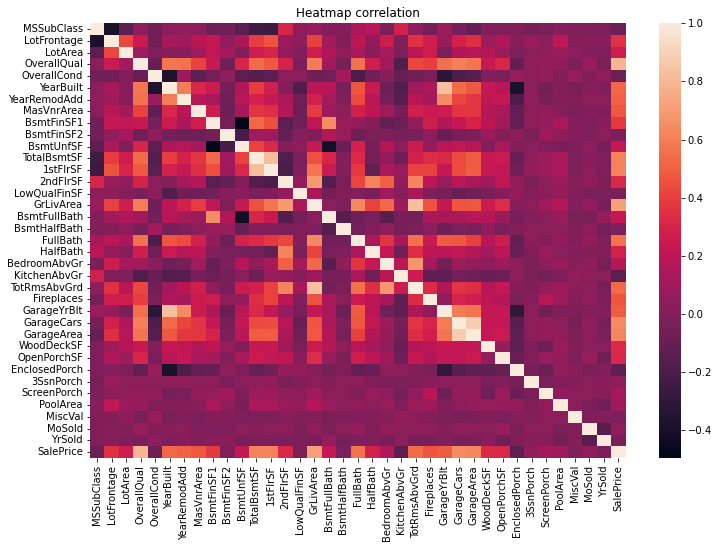

In [67]:
plt.figure(figsize=(12, 8))
plt.title("Heatmap correlation")
sns.heatmap(housing_prices_all.corr())

Post:La dernière ligne est celle qui nous intéresse le plus, elle montre la corrélation entre le prix de vente et les caractéristiques.

Nous pouvons remarquer que les caractéristiques les plus importantes sont `OverallQual` et `GrLiveArea`, suivi par `YearBuilt`, `YearRemodAdd` et `TotRmsAbvGrd`.

Par contre, des caractéristiques comme `MSSubClass`, `OverallCond` ou `KitchenAbvGr` ont très peu d'influence sur le prix d'une maison.

Pré: Sélection de 10/15 colonnes de façon arbitraire pour alléger la charge de travail.

In [68]:
categorical_columns = ['OverallQual', 'MSZoning', 'LandContour',
                       'Utilities', 'Neighborhood', 'BldgType', 'Exterior1st', 'GarageType']
numerical_columns = ['LotFrontage', 'LotArea',
                     'YearBuilt', 'BedroomAbvGr', 'GrLivArea', 'TotRmsAbvGrd']

housing_prices = housing_prices_all[categorical_columns + numerical_columns + ['SalePrice']]


Post: Explications des features choisies.

Categoriels:
  - OverallQual: Feature obligatoire + elle assez lié au prix d'une maison.
  - MSZoning: décrit la zone où se trouve la maison. Semble une caractéristique intéressante
  - LandContour: décrit à quel point le terrain est plat.
  - Utilities: décrit s'il y a de l'eau, gaz, électricité, etc
  - Neighborhood: Le quartier dans lequel se situe la maison
  - BldgType: Le type de batiment
  - Exterior1st: le matériau principal de la maison
  - GarageType: si la maison possède un garage et de quel type

Numerique:
  - LotFrontage: le nombre de pied de la propriété relié à la route.
  - LotArea: La taille de la propriété en pieds carrés
  - YearBuilt: L'année de construction
  - GrLiveArea: la surface habitable au dessus du sol (sans la cave)
  - BedroomAbvGr: le nombre de chambre
  - TotRmdAbvGrd: Le nombre de pièces au dessus du sol sans les salles de bains.

La majorité des features choisies sont en fonction des caractéristiques qui semblent les plus importantes dans le choix d'une maison et qui donc vont peut-être influencé le prix.

Nous avons donc un DataFrame avec uniquement les colonnes que l'on désire analyser avec en plus la colonne `SalePrice` qui est notre target


Pré: affichage des informations du dataframe

In [69]:
housing_prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1460 non-null   int64  
 1   MSZoning      1460 non-null   object 
 2   LandContour   1460 non-null   object 
 3   Utilities     1460 non-null   object 
 4   Neighborhood  1460 non-null   object 
 5   BldgType      1460 non-null   object 
 6   Exterior1st   1460 non-null   object 
 7   GarageType    1379 non-null   object 
 8   LotFrontage   1201 non-null   float64
 9   LotArea       1460 non-null   int64  
 10  YearBuilt     1460 non-null   int64  
 11  BedroomAbvGr  1460 non-null   int64  
 12  GrLivArea     1460 non-null   int64  
 13  TotRmsAbvGrd  1460 non-null   int64  
 14  SalePrice     1460 non-null   int64  
dtypes: float64(1), int64(7), object(7)
memory usage: 182.5+ KB


Post: Les informations du dataframe sont affichées. Nous pouvons voir le type de chaque colonnes ainsi que les colonnes comprenant des éléments `null`

Pré:  Affichage des colonnes ayant des éléments `null`
Les colonnes comme `LotFrontage` devrait apparaitre

In [70]:
columns_null_values = housing_prices.isnull().sum(axis=0)
columns_null_values = columns_null_values[columns_null_values > 0]
print(columns_null_values.shape[0])
columns_null_values

2


GarageType      81
LotFrontage    259
dtype: int64

Post: Il y a 2 colonnes comprenants des valeurs nulls
- GarageType: est à `None` si il n'y a pas de garage. Peut être remplacé par la chaine de caractère `"None"`
- LotFrontage: Si il n'y a pas de valeurs, c'est que la maison n'est pas relié à la route directement. Peut donc être remplacé par `0`
  
Ces valeurs seront remplacer grace à  des `SimpleImputer` dans le pipeline.

## Data mining and cleaning <a id="DMC"></a>

### Data Analyse <a id="DataAnalyse"></a>

Pré: Affichage de la comparaison entre toutes les features numériques entre-elles.

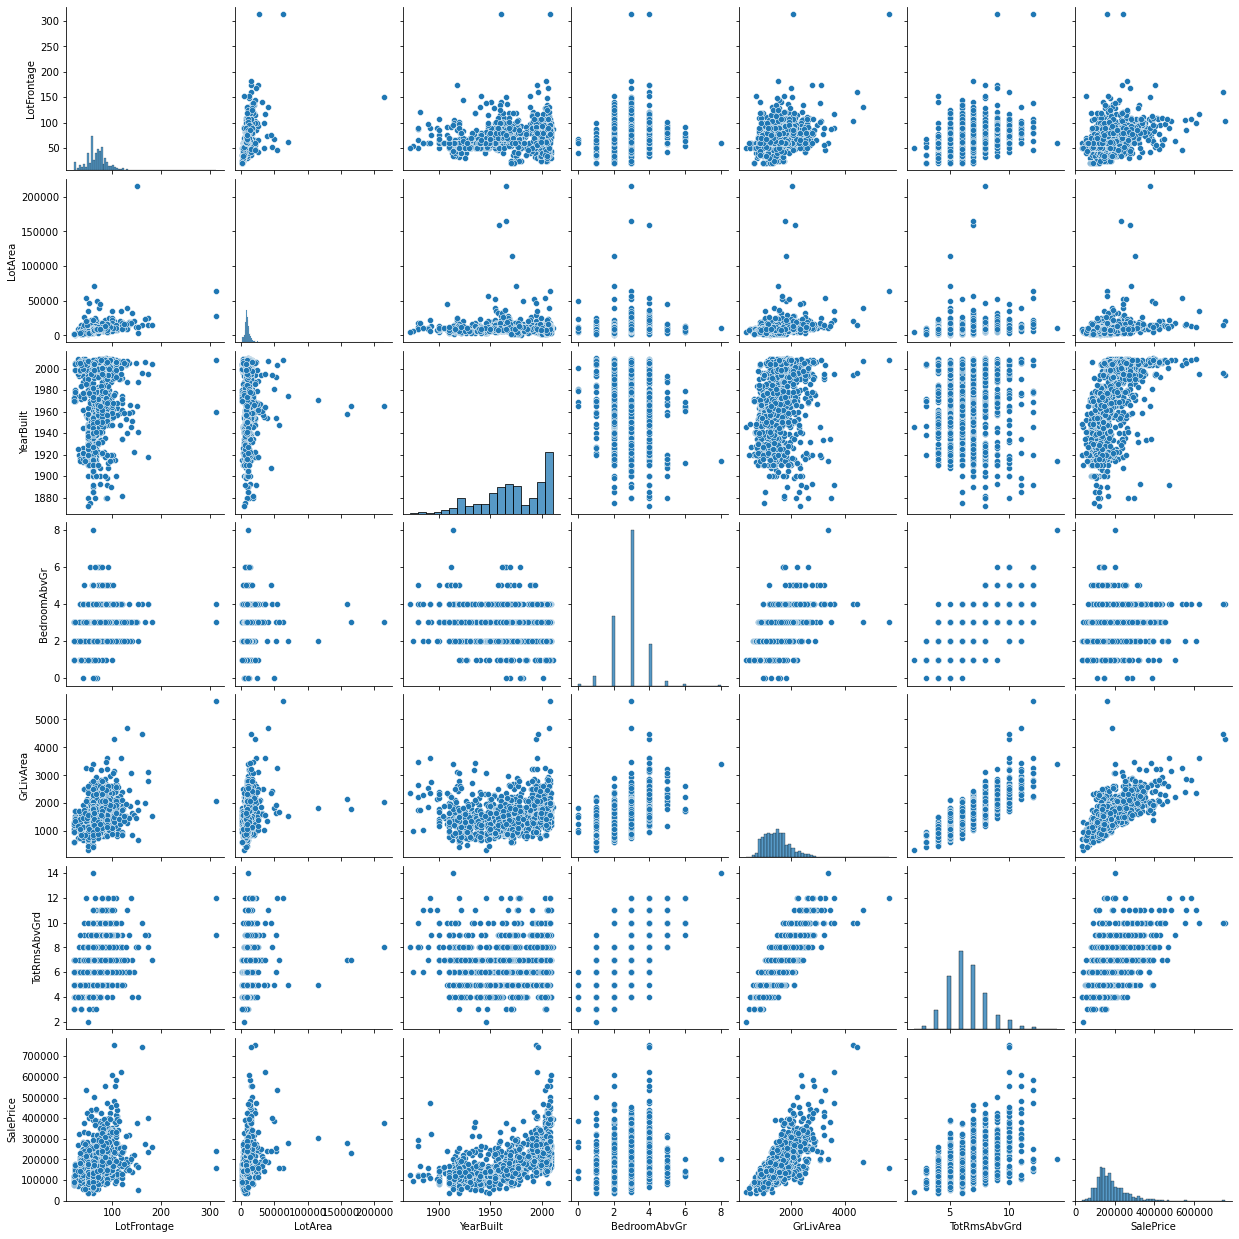

In [71]:
sns.pairplot(housing_prices[numerical_columns + ['SalePrice']],)


Post: Nous pouvons remarquer qu'il y a quelques valeurs extrêmes dans `LotFrontage` et `LotArea`. Le prix d'une maisons semble assez lié à des features comme `GrLivArea` et `TotRmdAbvGrd`  

Pré: Comparaison du prix d'une maison par rapport à sa qualité de finition.

<AxesSubplot:title={'center':'Répartition des prix par qualité de finitions'}, xlabel='OverallQual', ylabel='SalePrice'>

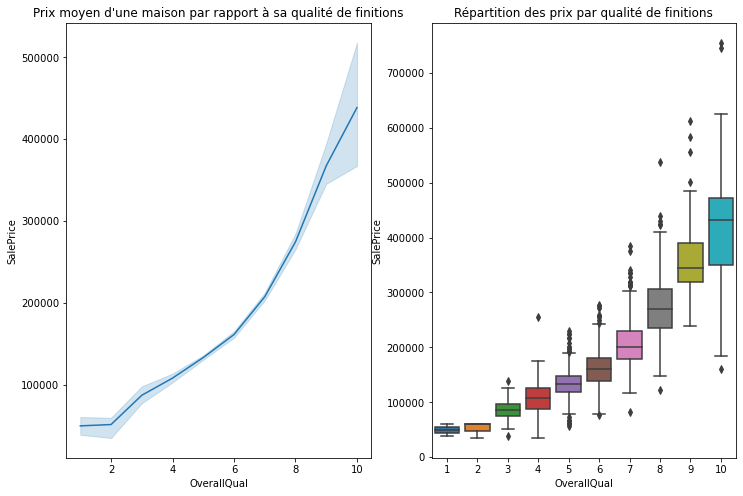

In [72]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Prix moyen d'une maison par rapport à sa qualité de finitions")
sns.lineplot(x="OverallQual", y="SalePrice", data=housing_prices)
plt.subplot(1, 2, 2)
plt.title("Répartition des prix par qualité de finitions")
sns.boxplot(x="OverallQual", y="SalePrice", data=housing_prices)


Post: Au plus la qualité augmente, au plus le prix d'une maison augmente. Mais au plus une maison est de bonne qualité, au plus les prix varient. 

Pré: Affichage de l'évolution du prix d'une maison par rapport à la surface habitable au dessus du sol avec sa regression lineair.

<AxesSubplot:title={'center':"Evolution du prix d'une maison par rapport à la surface habitable au dessus du sol"}, xlabel='GrLivArea', ylabel='SalePrice'>

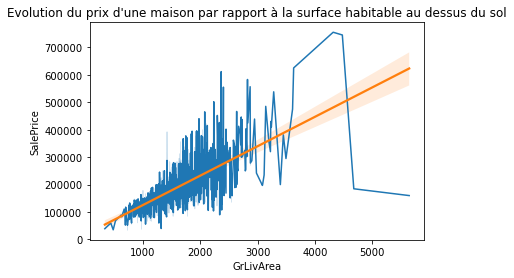

In [73]:
plt.title("Evolution du prix d'une maison par rapport à la surface habitable au dessus du sol")
sns.lineplot(x="GrLivArea", y="SalePrice", data=housing_prices)
sns.regplot(x="GrLivArea", y="SalePrice", data=housing_prices, scatter=False)


Post: Nous pouvons voir qu'il y a un lien entre les 2 caractéristiques jusqu'à environ 3500 pieds carrés. Après cette valeurs, le prix des maisons ne semble plus être lié avec la surface.

Pré: Affichage du prix d'une maison par rapport à l'année de construction

<AxesSubplot:title={'center':"Evolution du prix d'une maison par rapport à l'année de construction"}, xlabel='YearBuilt', ylabel='SalePrice'>

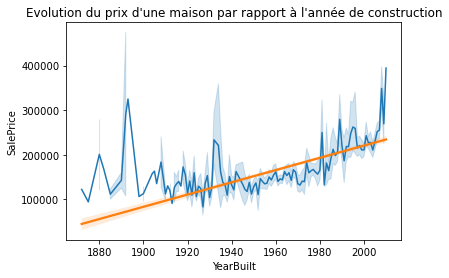

In [74]:
plt.title("Evolution du prix d'une maison par rapport à l'année de construction")
sns.lineplot(x="YearBuilt", y="SalePrice", data=housing_prices)
sns.regplot(x="YearBuilt", y="SalePrice", data=housing_prices, scatter=False)


Post: L'année de construction influe le prix d'une maison

Pré: Affichage de l'évolution du prix d'une maison par rapport au total de pieces au dessus du sol.

<AxesSubplot:title={'center':"Evolution du prix d'une maison par rapport au total de pieces au dessus du sol."}, xlabel='TotRmsAbvGrd', ylabel='SalePrice'>

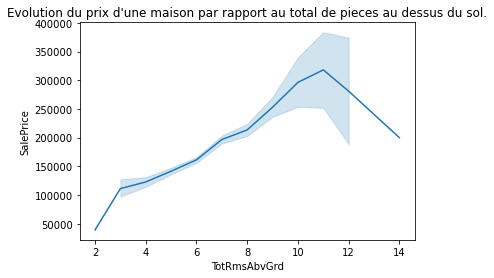

In [75]:
plt.title("Evolution du prix d'une maison par rapport au total de pieces au dessus du sol.")
sns.lineplot(x="TotRmsAbvGrd", y="SalePrice", data=housing_prices)


Post: Le prix d'une maison semble être lié au nombre de pièces dans une maison. Sauf si le nombre de pièce dépasse 12.

Pré: Affichage de la répartition du prix des maisons

Text(0.5, 1.0, 'Répartition du prix des maisons')

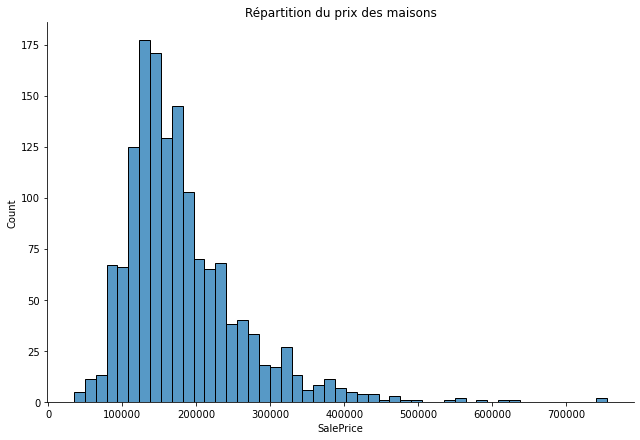

In [76]:
sns.displot(x="SalePrice", data=housing_prices, height=6, aspect=1.5)
plt.title("Répartition du prix des maisons")

Post: La répartition du prix des maisons a été affichée.

Pré: Affichage des informations sur les valeurs des features numériques

In [77]:
housing_prices.describe()

,OverallQual,LotFrontage,LotArea,YearBuilt,BedroomAbvGr,GrLivArea,TotRmsAbvGrd,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,6.099315,70.049958,10516.828082,1971.267808,2.866438,1515.463699,6.517808,180921.195890
std,1.382997,24.284752,9981.264932,30.202904,0.815778,525.480383,1.625393,79442.502883
min,1.000000,21.000000,1300.000000,1872.000000,0.000000,334.000000,2.000000,34900.000000
25%,5.000000,59.000000,7553.500000,1954.000000,2.000000,1129.500000,5.000000,129975.000000
50%,6.000000,69.000000,9478.500000,1973.000000,3.000000,1464.000000,6.000000,163000.000000
75%,7.000000,80.000000,11601.500000,2000.000000,3.000000,1776.750000,7.000000,214000.000000
max,10.000000,313.000000,215245.000000,2010.000000,8.000000,5642.000000,14.000000,755000.000000


Post: Nous pouvons observé des valeurs très extrême pour `LotFrontage`, `LotArea` et `GrLivArea`

Pour améliorer la précision du modèle, il faut enlever les valeurs trop extrêmes.

### Data Cleaning <a id="DataCleaning"></a>

Pré: Dans le tableau descriptif, nous avons pu voir des valeurs extrêmes pour les features `LotFrontage`, `LotArea` et `GrLivArea`, nous allons supprimer les lignes les plus êtrèmes pour essayer d'avoir un modèle le plus précis possible.

`LotFrontage` : <= 250
`LotArea`: <= 100000
`GrLivArea`: <= 5000

In [84]:
housing_prices = housing_prices[housing_prices['LotArea'].isna() | housing_prices['LotFrontage'] <= 250]
housing_prices = housing_prices[housing_prices['LotArea'] <= 100000]
housing_prices = housing_prices[housing_prices['GrLivArea'] <= 5000]
housing_prices.describe()


Post: les valeurs maximales sont moins extrêmes, nous devrions gagner en efficacité sur le modèle.

## Data Modeling <a id="DataModeling"></a>

Pré: Séparation des features et de la target

In [88]:
X = housing_prices.drop('SalePrice', axis=1)
y = housing_prices['SalePrice']

Post: X contient les Features et y la target pour chaque ligne

Pré: Séparation du train et test set.

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Post: Le train et test set ont été séparés. Il y a 20% des données dans le test set.

### Preprocessing <a id="Prepro"></a>

Pré: Création des pipelines pour le pré-processing

In [90]:
numerical_pipeline = make_pipeline(SimpleImputer(strategy="constant", fill_value=0),StandardScaler())
categorical_pipeline = make_pipeline(SimpleImputer(strategy="constant", fill_value="None"), OneHotEncoder(handle_unknown="ignore"))

preprocessor = make_column_transformer(
    (numerical_pipeline, numerical_columns), (categorical_pipeline, categorical_columns))


Post: `numerical_pipeline` va transformer toutes les valeurs nulls par des `0` et `categorical_pipeline` par des `None`. Ensuiite les valeurs numériques vont être transformer grâce au `StandardScaler` et les catégories grâce au `OneHotEncoder` 

Un preprocessor est donc créé grâce aux 2 pipelines. Il sera utilisé par la suite dans la création du modèle.

### Linear Regression
pour un problème de ce type, il faut utiliser la régression. On ne cherche pas à catégoriser un ensemble de donnés mais à trouver une "quantité", le prix d'une maison.
Nous allons donc uniquement utilisé la regression linéaire

Pré: Utilisation de GridSearchCV avec une pipeline qui contient le preprocessor et la regression linéaire. Nous testons le modèle avec une Cross Validation égale à 5 et en modifiant le paramètre `fit_intercept` du `LinearRegression`

In [91]:
model_lr = make_pipeline(preprocessor, LinearRegression())
grid_lr = GridSearchCV(model_lr, param_grid={'linearregression__fit_intercept': [True, False]}, cv=5)
grid_lr.fit(X_train, y_train)
print("score: " + str(grid_lr.score(X_test, y_test)))
print("Best params: " + str(grid_lr.best_params_))

score: 0.8735348676974157
Best params: {'linearregression__fit_intercept': False}


Post: Le modèle a un score de 87.35%, nous obtenons un meilleur score avec en Hyperparamètre: `fit_intercept=True`

Nous pouvons certainement améliorer ce résultat en modifiant les features sélectionnées au début. Néanmoins, le résultat semble acceptable.

## Conclusion <a id="Conclusion"></a>

Nous n'avions ici qu'un seul modèle à tester, et qui possède peu d'hyper paramètre. Le choix des features de bases ayant été fait manuellement, ce n'est peut-être pas les meilleurs qui ont été selectionnées.

Cependant, le résultat peut être consédiré comme satisfaisant avec un score de 0.87.
